In [78]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import folium
import pandas as pd
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

# Settings
import matplotlib

matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))

# Read data
train_data = pd.read_csv('../input/train.csv')


# View data
train_data.head()
print('Data Shape',train_data.shape)
train_data.info()

# Remove passenger_count outliers
train_data = train_data[train_data['nr_pasageri']>0]
train_data = train_data[train_data['nr_pasageri']<9]

# train_data = train_data[train_data['pickup_longitude'] <= -73.968285]
# train_data = train_data[train_data['pickup_longitude'] >= -74.0059]
# train_data = train_data[train_data['pickup_latitude'] <= 40.748817]
# train_data = train_data[train_data['pickup_latitude'] >= 40.7128]
# train_data = train_data[train_data['dropoff_longitude'] <= -73.968285]
# train_data = train_data[train_data['dropoff_longitude'] >= -74.0059]
# train_data = train_data[train_data['dropoff_latitude'] <= 40.748817]
# train_data = train_data[train_data['dropoff_latitude'] >= 40.7128]

# Remove coordinate outliers
train_data = train_data[train_data['longitudine_pornire'] <= -73.75]
train_data = train_data[train_data['longitudine_pornire'] >= -74.03]
train_data = train_data[train_data['latitudine_pornire'] <= 40.85]
train_data = train_data[train_data['latitudine_pornire'] >= 40.63]
train_data = train_data[train_data['longitudine_sosire'] <= -73.75]
train_data = train_data[train_data['longitudine_sosire'] >= -74.03]
train_data = train_data[train_data['latitudine_sosire'] <= 40.85]
train_data = train_data[train_data['latitudine_sosire'] >= 40.63]

# Remove trip_duration outliers
trip_duration_mean = np.mean(train_data['durata_cursa'])
trip_duration_std = np.std(train_data['durata_cursa'])
train_data = train_data[train_data['durata_cursa']<=trip_duration_mean + 2*trip_duration_std]
train_data = train_data[train_data['durata_cursa']>= trip_duration_mean - 2*trip_duration_std]

# Confirm removal
train_data.describe().transpose()

train_data['data_timp_pornire'] = pd.to_datetime(train_data.data_pornire) # Pickups
train_data['data_timp_sosire'] = pd.to_datetime(train_data.data_sosire) # Drop-offs

# Confirm changes
train_data.info()

# Delimit pickup_datetime variable 

train_data['data_pornire'] = train_data['data_timp_pornire'].dt.date # Extract date
train_data['timp_pornire'] = train_data['data_timp_pornire'].dt.time # Extract time

# Delimit dropoff_datetime variables
train_data['data_sosire'] = train_data['data_timp_sosire'].dt.date # Extract date
train_data['timp_sosire'] = train_data['data_timp_sosire'].dt.time # Extract time

# Additional pickup features
train_data['luna_pornire'] = train_data['data_timp_pornire'].dt.month # Extract month
# train_data['pickup_month'] = train_data.pickup_datetime.dt.to_period('M') # Extract yearmonth
#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
train_data['ora_pornire'] = train_data['data_timp_pornire'].dt.hour # Extract hour
train_data['ziua_pornire'] = train_data['data_timp_pornire'].dt.dayofweek # Extract day of week

# Drop concatentated timestamp columns
train_data.drop(['data_pornire'], axis = 1, inplace = True)
train_data.drop(['data_sosire'], axis = 1, inplace = True)

def displayMap():
    #detecting the pickups latitude and longitudes which are outside NYC.
    outside_NYC = train_data[((train_data.latitudine_pornire <= 40.5774) | (train_data.longitudine_pornire <= -74.15) | (train_data.latitudine_pornire >= 40.9176) | (train_data.longitudine_pornire >= -73.7004))]
    #latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
    #is negative and becomes -90 at south pole.
    #Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
    #and is negative.

    m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

    outside_pickups = outside_NYC.head(25000)

    for i,j in outside_pickups.iterrows():
        if j["latitudine_pornire"] != 0:
            folium.Marker([j["latitudine_pornire"], j["longitudine_pornire"]]).add_to(m)
    m

def curba_asimetrie():
    # Mean distribution
    mu = train_data['durata_cursa'].mean()

    # Std distribution
    sigma = train_data['durata_cursa'].std()
    num_bins = 100

    # Histogram 
    fig = plt.figure(figsize=(8.5, 5))
    n, bins, patches = plt.hist(train_data['durata_cursa'], num_bins, normed=1,
                               edgecolor = 'black', lw = 1, alpha = .40)
    # Normal Distribution
    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    plt.xlabel('durata_cursa')
    plt.ylabel('Densitate de probabilitate')

    # Adding a title
    plt.title(r'$\mathrm{Durata\ cursa\ -\ curba\ de\ asimetrie}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
    plt.grid(True)
    #fig.tight_layout()
    plt.show()

    # Statistical summary
    train_data.describe()[['durata_cursa']].transpose()
    
def durata_cursa_grafic():
    mu = train_data['durata_cursa'].mean()
    sigma = train_data['durata_cursa'].std()
    num_bins = 100


    plt.figure(figsize = (12,8))
    sns.kdeplot(train_data['durata_cursa'].values, shade = True, cumulative = False)
    plt.tick_params(labelsize = 20)
    plt.xlabel("Trip Duration", fontsize = 20)
    plt.title("PDF of Trip Duration", fontsize = 20)
    # Normal Distribution
    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    plt.tick_params(labelsize = 20)
    plt.xlabel('durata_cursa')
    plt.ylabel('Densitate de probabilitate')

    plt.show()


    # Statistical summary
    train_data.describe()[['durata_cursa']].transpose()

def durata_cursa_pe_zi():
    # Trips by Hour and Day of Week
    trip_duration_median = train_data['durata_cursa'].median()
    plt.figure(figsize=(8.5,5))
    pickup_hourday = train_data.groupby(['ora_pornire','ziua_pornire'])['durata_cursa'].median().unstack()
    hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                       lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
    # Customize tick label size
    hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

    # Customize tick labels of the y-axis
    hourday_graph.set_xticklabels(labels = ['Luni', 'Marti', 'Miercuri','Joi','Vineri','Sambata','Duminica'])

    # Bolding horizontal line at y = 0
    hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

    # Remove the label of the x-axis
    hourday_graph.xaxis.label.set_visible(False)

    # Add signature bar
    hourday_graph.text(x = -.8,  y = -4,
                       s = ' ©KAGGLE                                          Source: NYC Taxi and Limousine Commission (TLC)   ',
    fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

    # plt.ylabel('pickup_hour (military time)')
    # plt.xlabel('pickup_weekday (Mon - Sun)')
    # plt.title('Median Trip Duration by Pickup Hour and Day of Week')
    plt.show()

def curse_grafic(): 
    longitude = list(train_data.longitudine_pornire) + list(train_data.longitudine_sosire)
    latitude = list(train_data.latitudine_pornire) + list(train_data.latitudine_sosire)
    plt.figure(figsize = (10,8))
    plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
    plt.title('Reprezentare grafica a curselor')
    plt.show()
    
def cluster_new_york():
    # Create data frame of coordinates
    loc_df = pd.DataFrame()
    loc_df['longitude'] = longitude
    loc_df['latitude'] = latitude

    # Clusters of New York
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
    loc_df['label'] = kmeans.labels_
    loc_df = loc_df.sample(200000)
    plt.figure(figsize = (12,7))
    for label in loc_df.label.unique():
        plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.8, markersize = 0.8)
    plt.title('Clusters of New York')
    plt.show()

def corelatie_variabile():
    # Correlations to trip_duration
    corr = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
    cor_dict = corr['durata_cursa'].to_dict()
    del cor_dict['durata_cursa']
    print("List the numerical features in decending order by their correlation with trip_duration:\n")
    for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
        print("{0}: {1}".format(*ele))

    # Correlation matrix heatmap
    corrmat = train_data.corr()
    plt.figure(figsize=(12, 7))

    # Number of variables for heatmap
    k = 76
    cols = corrmat.nlargest(k, 'durata_cursa')['durata_cursa'].index
    cm = np.corrcoef(train_data[cols].values.T)

    # Generate mask for upper triangle
    mask = np.zeros_like(cm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.set(font_scale=1)
    sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                     fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                     xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
    plt.show()

train_data['cursa_marcata'] = train_data['cursa_marcata'].map({'N':0,'Y':1})
train_data.drop(['data_timp_pornire','timp_pornire','data_timp_sosire', 'timp_sosire','id'], 
                axis = 1, inplace = True)

# Split
# Create matrix of features
X = train_data[['id_sofer', 'nr_pasageri', 'longitudine_pornire',
       'latitudine_pornire', 'longitudine_sosire', 'latitudine_sosire',
       'luna_pornire', 'ora_pornire',
       'ziua_pornire']] # double brackets!

# Create array of target variable 
y = train_data['durata_cursa']

# Create train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fit
# Import model
from sklearn.tree import DecisionTreeRegressor

# Instantiate model object
dtree = DecisionTreeRegressor(max_depth=8)

# Fit to training data
dtree.fit(X_train,y_train)
print(dtree)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score It
from sklearn import metrics
print('\nDecision Tree Regression Performance Metrics')
print('R^2=',metrics.r2_score(y_test,y_pred_dtree))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_dtree))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_dtree))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_dtree)))

# Load test data
def citireFisierDateTest(file):
    test_data = pd.read_csv(file)
    # Convert timestamps to date objects
    test_data['pickup_datetime'] = pd.to_datetime(test_data.data_pornire) # Pickups

    # Delimit pickup_datetime variable 
    test_data['data_plecare'] = test_data['pickup_datetime'].dt.date # Extract date
    test_data['timp_plecare'] = test_data['pickup_datetime'].dt.time # Extract time

    # Additional pickup features
    test_data['luna_pornire'] = test_data['pickup_datetime'].dt.month # Extract month

    #train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
    test_data['ora_pornire'] = test_data['pickup_datetime'].dt.hour # Extract hour
    test_data['zi_pornire'] = test_data['pickup_datetime'].dt.dayofweek # Extract day of week
    
def predictie_durata_calatorie():
    X_test= test_data[['id_sofer','nr_pasageri', 'longitudine_pornire',
           'latitudine_pornire', 'longitudine_sosire', 'latitudine_sosire',
            'luna_pornire', 'ora_pornire',
           'zi_pornire']]

    # Feed features into random forest
    y_pred= dtree.predict(X_test)
    submission = pd.DataFrame({
        'trip_duration': y_pred
    })
    print(submission)
    
    # Create contest submission
    submission = pd.DataFrame({
        'Id':1,
        'trip_duration': y_pred
    })
    submission.to_csv('mytaxisubmission.csv',index = False)

Data Shape (1048575, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
id                     1048575 non-null object
id_sofer               1048575 non-null int64
data_pornire           1048575 non-null object
data_sosire            1048575 non-null object
nr_pasageri            1048575 non-null int64
longitudine_pornire    1048575 non-null float64
latitudine_pornire     1048575 non-null float64
longitudine_sosire     1048575 non-null float64
latitudine_sosire      1048575 non-null float64
cursa_marcata          1048575 non-null object
durata_cursa           1048575 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 88.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033016 entries, 0 to 1048574
Data columns (total 13 columns):
id                     1033016 non-null object
id_sofer               1033016 non-null int64
data_pornire           1033016 non-null object
data_sosire            10330

In [100]:
from IPython.display import HTML
def exportCSV():
    HTML('''<script>
code_show=true; 
function code_toggle2() {
 window.open('mytaxisubmission.csv')
} 
$( document ).ready(code_toggle2);
</script>
''')
    
exportCSV()

In [97]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.code_cell:first-child').hide();
 } else {
 $('div.code_cell:first-child').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [79]:
displayMap()

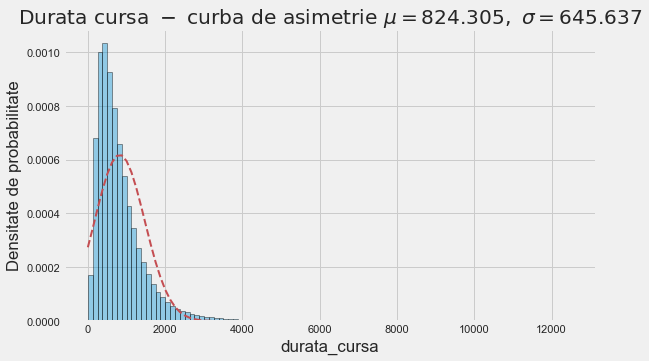

In [80]:
curba_asimetrie()

In [81]:
durata_cursa_grafic()

NameError: name 'durata_cursa_grafic' is not defined

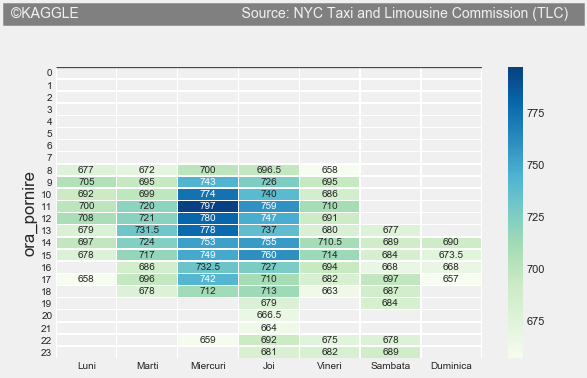

In [59]:
durata_cursa_pe_zi()

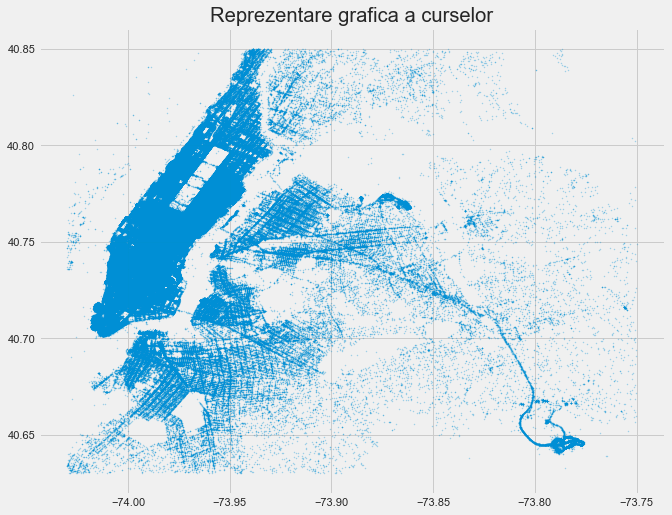

In [60]:
curse_grafic()

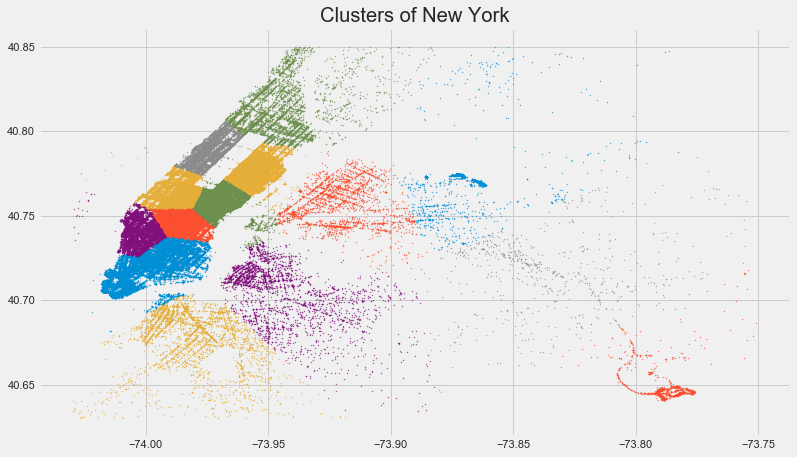

In [61]:
cluster_new_york()

List the numerical features in decending order by their correlation with trip_duration:

longitudine_pornire: 0.36241596694672223
longitudine_sosire: 0.2543550906959195
latitudine_pornire: -0.23578933817563946
latitudine_sosire: -0.196500196851999
ora_pornire: 0.030887792384612332
ziua_pornire: -0.0215554032223168
nr_pasageri: 0.014259878789089622
luna_pornire: 0.01202331281575298


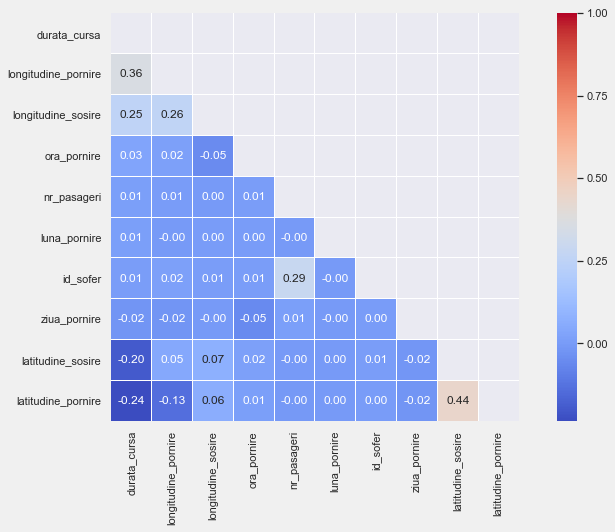

In [26]:
corelatie_variabile()

In [82]:
citireFisierDateTest('../input/test_c.csv')

In [102]:
prezicere_durata_calatorie()

from IPython.display import HTML
HTML('''    
    <form action="javascript:code_toggle()"><input type="submit" value="Download CSV."></form>
''')

   trip_duration
0        673.993
1        526.578
2       1494.672
3        555.564
4        673.993
5        673.993
6        673.993
7       1078.538


In [92]:
exportCSV()